## Homework 4.3: Mutant stability analysis (30 pts)

This problem compares predicted mutant stabilities, $\Delta \Delta G$ values, with the experimentally determined mutant $\Delta \Delta G$ values from [Nisthal et al., “Protein stability engineering insights revealed by domain-wide comprehensive mutagenesis,” PNAS, 2019](https://doi.org/10.1073/pnas.1903888116). The experimental data can be found in the ProtaBank protein engineering database: https://www.protabank.org. Make an account for yourself and login. Select “Search” from the menu bar and enter gwoS2haU3
into the search field to pull up the desired data (note that any extra spaces appended to the ID will cause the search to fail). Select the single entry that appears. Scroll down to “Structure view and single mutant data analysis” and then select “Derived” under “Filter by Assay Type:”. After the “Filter by Assay:” appears, select “ddG(mAvg)_mean”. Scroll down to “Study data” and export the data in CSV format. The CSV file is a comma delimited text file that contains the relevant study data. The second column of the file is a description of a particular mutant using single letter amino acid codes and a two digit residue position number. For example, the data entry on line 2 is “M01A” corresponding to wild-type methionine at position 1 mutated to alanine. The actual change in stability values, $\Delta \Delta G$ values, are found in the “Data” column (column 4). Note that the mutants for a particular position are not necessarily all grouped together and not all possible 1,064 mutants were measured. You should have data for 935 mutants. In addition, some mutants could not be properly characterized; these mutants have “-4” entered for their $\Delta \Delta G$.

<hr>

## Part 1

Use the Triad application “Single Mutant Stability ($\Delta \Delta G$)” (“Applications/Analysis/Single Mutant Stability ($\Delta \Delta G$)” to compute the $\Delta \Delta G$ for all single mutations using the Rosetta force field (with the corresponding 1pga_prepared_rosetta.pdb file). Select all 56 positions for “Sites” and “all” for “Restypes”. Use the default parameters for everything else. After the job completes, “Export” the data under “7-Output/Mutant details/Export,” rename it to "ipga_rosetta_ddG" and submit it with your homework. Note that the mutant designations have the chain designator prefix (e.g., the “A_” in “A_E27Y”) unlike the data from ProtaBank. Importantly, this Triad application is structured so that stabilizing mutations have negative $\Delta \Delta G$ values. When comparing to the experimental data, flip the sign of the Triad $\Delta \Delta G$ values. Download the log file, rename it to "ipga_rosetta_ddG.txt."

Generate a histogram similar to Figure 3A in the Nisthal et al. paper that includes the 1,064 calculated mutant $\Delta \Delta G$ values.
 
Generate a scatter plot similar to Figure 7A in the Nisthal et al. paper with the experimental $\Delta \Delta G$ values on the x-axis and the calculated $\Delta \Delta G$ values on the y-axis. Use only experimental/calculated data pairs where the experimental data have been determined. That is, do not use experimental data with -4 kcal/mol (see note above). Color code the data points using the core, boundary, and surface classification computed in problem 4.2.3. Perform linear regression on all plotted data points.
 
Qualitatively speaking, what are the general trends in the correlations between experimental and calculated $\Delta \Delta G$ values for the core, boundary and surface groups?

<hr>

In general the ddG values are more varied (more outliers) for the surface residues. This is likely because there are more surface residues and they are less sterically hindered (more free to rotate). This can result in unreasonable ddG values for these residues. The surface residues are also clustered around experimental ddG values between -1 and 1. The core and boundary residues have a wide range of experimental ddG values on average.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(df, bin_width, x_min, x_max):
    # bin the data in 0.25 kcal/mol bins
    bins = np.arange(df.iloc[:, 4:].min().min(), df.iloc[:, 4:].max().max(), bin_width)
    count, binned = np.histogram(df.iloc[:,4:], bins = bins)

    count = count/count.sum()

    fig = plt.figure()
    plt.bar(binned[:-1], count)
    plt.xlabel('Binding Free Energy (kcal/mol)')
    plt.ylabel('Probability')
    plt.title('Calculated Data')
    plt.show()

    fig = plt.figure()
    plt.bar(binned[:-1], count)
    plt.xlabel('Binding Free Energy (kcal/mol)')
    plt.ylabel('Probability')
    plt.title('Zoomed Calculated Data')
    plt.xlim(x_min, x_max)
    plt.show()

In [2]:
def plot_hist_exp(df):
    # bin the data in 0.25 kcal/mol bins
    bins = np.arange(df['Data'].min(), df['Data'].max(), .25)
    count, binned = np.histogram(df.iloc[:,3], bins=bins)

    count = count/count.sum()

    plt.bar(binned[:-1], count)
    plt.xlabel('Binding Free Energy (kcal/mol)')
    plt.ylabel('Probability')
    plt.title('Experimental Data')
    plt.show()

In [3]:
def plot_scatter(df, df2, x_min, x_max):
    modeled_list = []
    class_list = []
    for i in range(len(df2)):
        mut = df2.iloc[i, 1]
        modeled = df[df.site == mut[0] + str(int(mut[1:-1]))].loc[:, mut[-1]].item()
        modeled_list.append(modeled)
        class_list.append(df[df.site == mut[0] + str(int(mut[1:-1]))].Class.item())
    df2['modeled'] = modeled_list
    df2['class'] = class_list

    df_2_bndry = df2[df2['class'] == 'bndry']
    df_2_surf = df2[df2['class'] == 'surf']
    df_2_core = df2[df2['class'] == 'core']

    b, a = np.polyfit(df2['Data'], df2['modeled'], deg=1)
    y_pred = a + b*df2['Data']

    from sklearn.metrics import r2_score
    r2 = r2_score(df2['modeled'], y_pred)

    fig = plt.figure()
    plt.scatter(df_2_bndry['Data'], df_2_bndry['modeled'], marker = 'o', alpha = 0.5, label = 'Boundary')
    plt.scatter(df_2_core['Data'], df_2_core['modeled'], marker = 'o', alpha = 0.5, label = 'Core')
    plt.scatter(df_2_surf['Data'], df_2_surf['modeled'], marker = 'o', alpha = 0.5, label = 'Surface')
    plt.plot(df2['Data'], y_pred, c='k', lw=0.5, label = f'Linear Fit, r^2 = ' + f'{r2:.2f}')
    plt.xlabel('Experimental ddG (kcal/mol)')
    plt.ylabel('Modeled ddG (kcal/mol)')
    plt.title('Exp. v Modeled ddG')
    plt.legend()
    plt.show()

    fig = plt.figure()
    plt.scatter(df_2_bndry['Data'], df_2_bndry['modeled'], marker = 'o', alpha = 0.5, label = 'Boundary')
    plt.scatter(df_2_core['Data'], df_2_core['modeled'], marker = 'o', alpha = 0.5, label = 'Core')
    plt.scatter(df_2_surf['Data'], df_2_surf['modeled'], marker = 'o', alpha = 0.5, label = 'Surface')
    plt.plot(df2['Data'], y_pred, c='k', lw=0.5, label = f'Linear Fit, r^2 = ' + f'{r2:.2f}')
    plt.xlabel('Experimental ddG (kcal/mol)')
    plt.ylabel('Modeled ddG (kcal/mol)')
    plt.title('Zoomed Exp. v Modeled ddG')
    plt.legend()
    plt.ylim(x_min, x_max)
    plt.show()

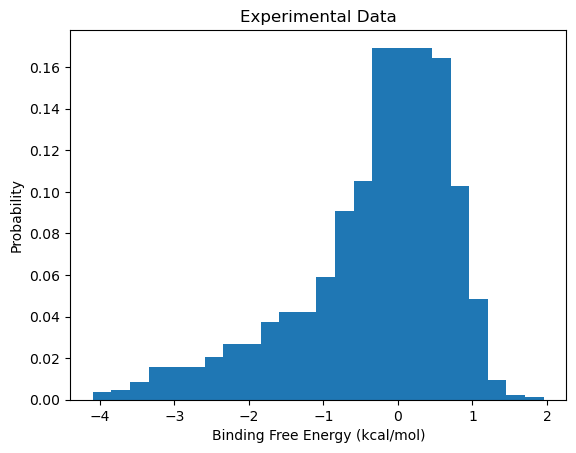

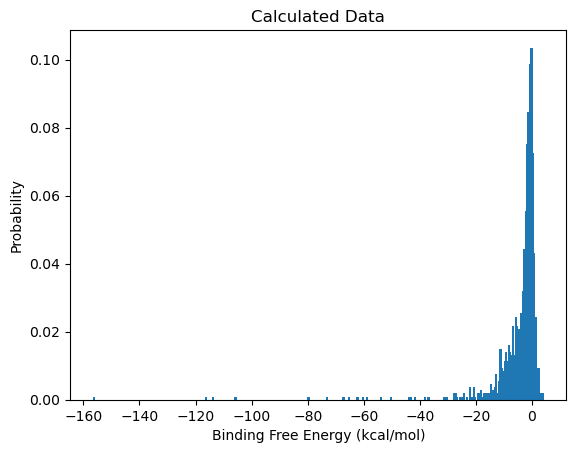

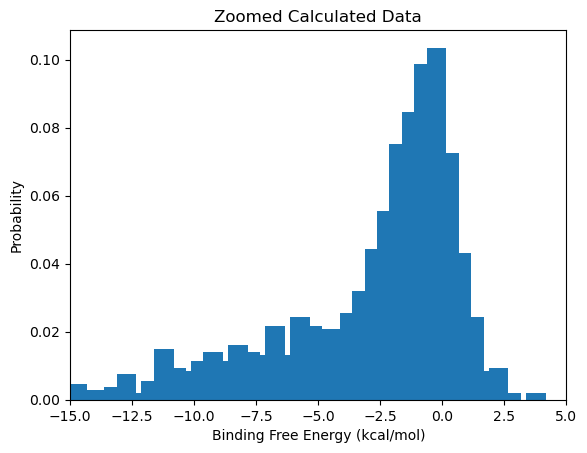

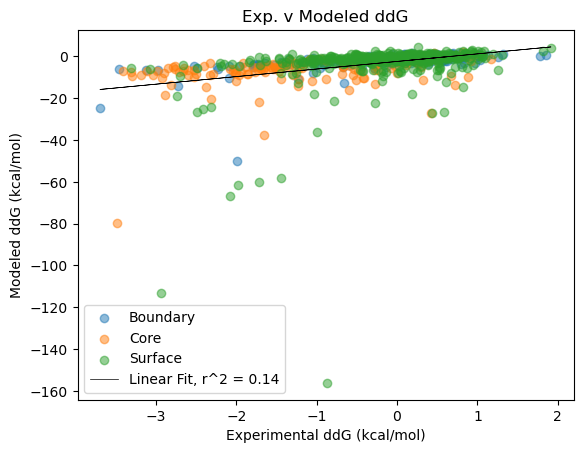

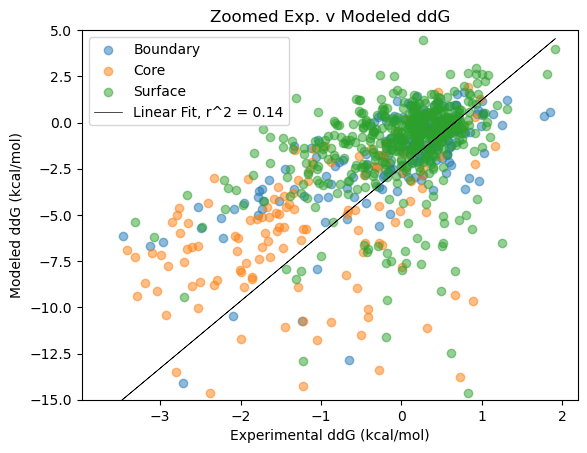

In [4]:
df_exp = pd.read_csv('ProtaBank.csv')
df_exp = df_exp.mask(df_exp.Data == -4, other=np.nan).dropna(subset='Data')

df_rose = pd.read_csv('ipga_rosetta_ddG.csv')
df_rose['site'] = df_rose['site'].apply(lambda x: x.split('_')[1])
df_rose.iloc[:, 3:] = df_rose.iloc[:,3:].astype(float).multiply(-1)

# plot hist
plot_hist_exp(df_exp)
plot_hist(df_rose, 0.5, -15, 5)

# plot scatter
plot_scatter(df_rose, df_exp, -15, 5)

## Part 2

Repeat the process with the Phoenix force field. How do the Rosetta and Phoenix force fields compare in terms of ability to recapitulate the experimental data? What approaches could you take to improve the ability of the calculations to achieve higher correlation with the experimental data?

<hr>

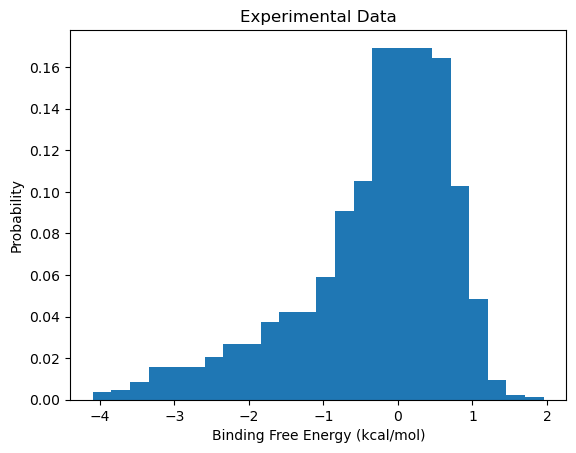

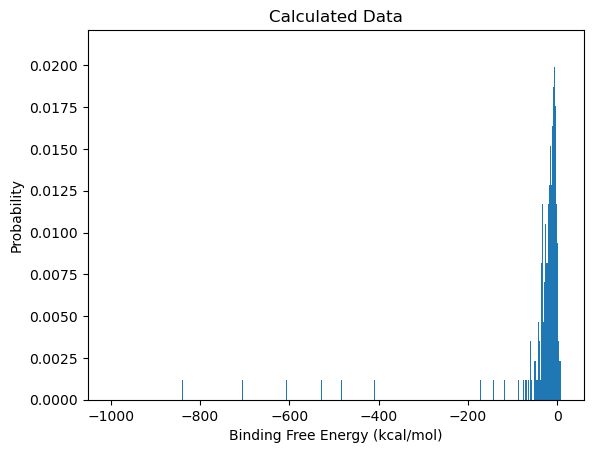

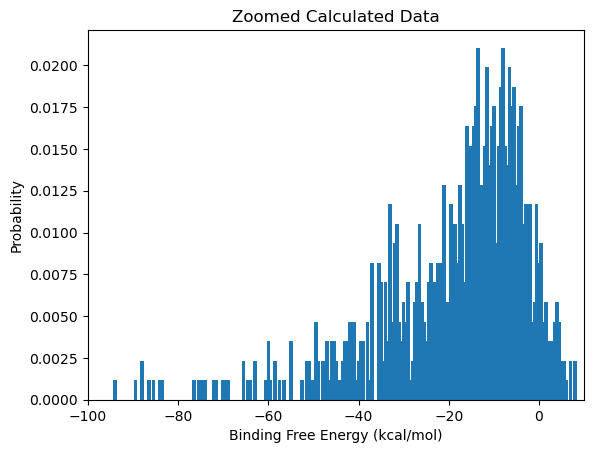

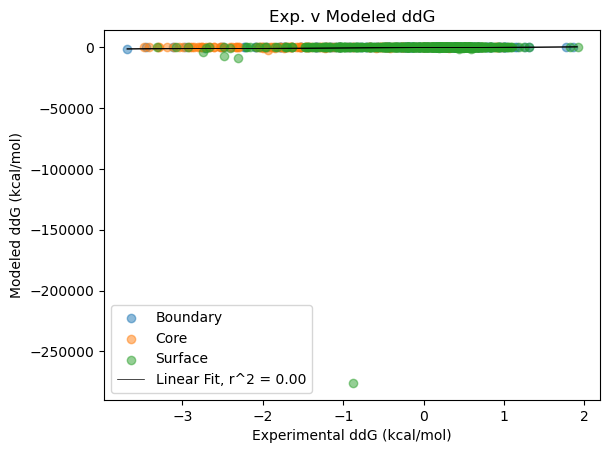

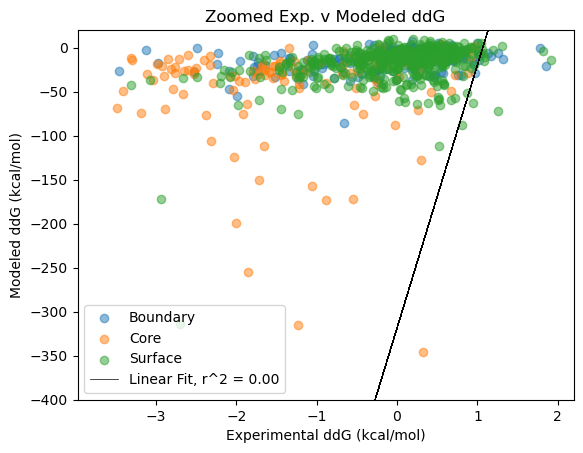

In [7]:
df_phoenix = pd.read_csv('ipga_phoenix_ddG.csv')
df_phoenix['site'] = df_phoenix['site'].apply(lambda x: x.split('_')[1])
df_phoenix.iloc[:, 3:] = df_phoenix.iloc[:,3:].astype(float).multiply(-1)

# set outliers to -1000 (histogram only)
df_phoenix_temp = df_phoenix.iloc[:,4:].mask(df_phoenix.iloc[:,4:] < -1000, other= -1000)

# plot hist
plot_hist_exp(df_exp)
plot_hist(df_phoenix_temp, 0.5, -100, 10)

# plot scatter
plot_scatter(df_phoenix, df_exp, -400, 20)


Overall, the Rosetta model performs better than Phoenix when compared to experimentally obtained ddG values. To improve the models performance, one could set a maximum and minimum allowable ddG value to prevent such large negative outliers. You could also empose a constraint to require that all calculated points be within the standard deviation of each class.